### Обучение с учителем

**Обучение с учителем** = есть целевая переменная (таргет), которую мы предсказываем

_Регрессия_ - таргет непрерывен
- Предсказание цен на дома
- Предсказание спроса на товары
- ...


_Классификация_ - Таргет принимает 2 (иногда k) значений
- Кредитный скоринг: вернет кредит (target=0) или нет (target=1)
- Определение вида животного по фото (0 - лев, 1 - пантера, 2 - леопард, ... , k - гепард) 
- ...

**Обучение без учителя** = нет целевой переменной:
- Разделение данных на группы
- ...

_Пример реального проекта_ : В Delivery Club мы разделям все рестораны Москвы на группы, чтобы ставить курьеров на группу ресторанов 

**ЭТАПЫ Data Science проекта:**
1. Определить бизнес проблему
2. Убедить бизнес, что ее можно и нужно решать с помощью ML =)
3. Перевести бизнес проблему в ML-задачу
4. Выбрать подходящие ML и бизнес метрики
---------------------------------------------------------------------------
5. Загрузка данных (все вебинары + курс по SQL)
6. EDA: визуализация данных (вебинар 3)
7. Очистка данных и feature engineering (вебинар 2)
8. **_Разбиение данных на train и test_**
9. **_Построение ML моделей*_**
10. **_Оценка качества ML моделей и выбор наилучшей_**

---------------------------------------------------------------------------
11. Доказать бизнес-заказчику, что модель хорошо работает (отдельный курс: А/В тесты в курсе мат. статистики)
12. Внедрение модели в production (отдельный курс) 
13. Улучшение модели
14. Поддержка модели

**Подключение библиотек и скриптов**

In [1]:
#conda install -c conda-forge lightgbm

In [2]:
# pip install lightgbm

In [8]:
import warnings

warnings.filterwarnings('ignore')

In [9]:
# Основные библиотеки
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor

# Метрики
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# Визуализация картинок
from IPython.display import Image

In [10]:
matplotlib.rcParams.update({'font.size': 14})

#### Пути к файлам

In [11]:
PREPEARED_DATASET_PATH = './Webinar/housing_prepared.csv'
REPORTS_FILE_PATH = './reports/'
MODEL_FILE_PATH = './model/'

In [12]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:
df = pd.read_csv(PREPEARED_DATASET_PATH)
df = reduce_mem_usage(df)
df.head(3)

Memory usage of dataframe is 1.95 MB
Memory usage after optimization is: 0.75 MB
Decreased by 61.5%


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,1,0,452600.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,1,0,358500.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,1,0,352100.0


In [14]:
df.dtypes

longitude             float32
latitude              float32
housing_median_age    float32
total_rooms           float32
total_bedrooms        float32
population            float32
households            float32
median_income         float32
<1H OCEAN                int8
INLAND                   int8
NEAR BAY                 int8
NEAR OCEAN               int8
median_house_value    float32
dtype: object

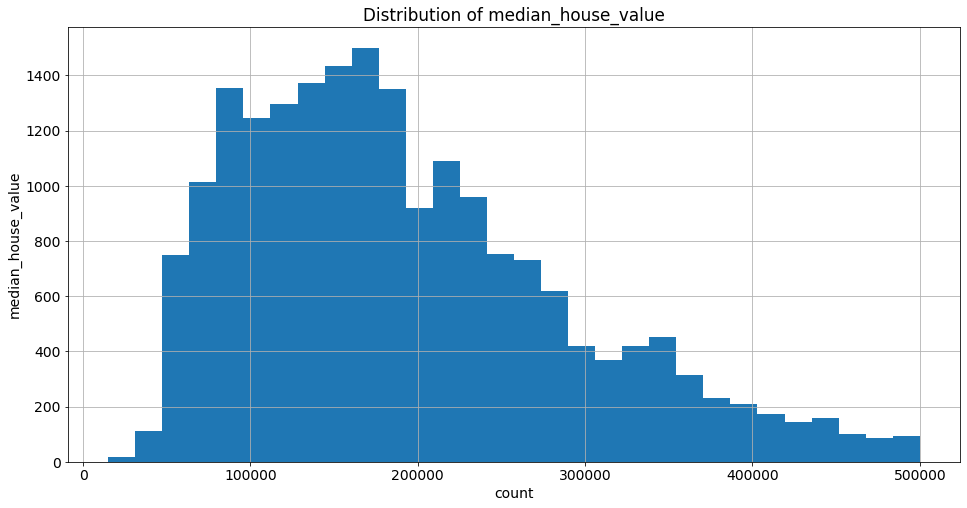

In [15]:
plt.figure(figsize=(16, 8))

df['median_house_value'].hist(bins=30)
plt.xlabel('count')
plt.ylabel('median_house_value')

plt.title('Distribution of median_house_value')
plt.show()

In [16]:
df = df[df['median_house_value'] <= 500000].reset_index()

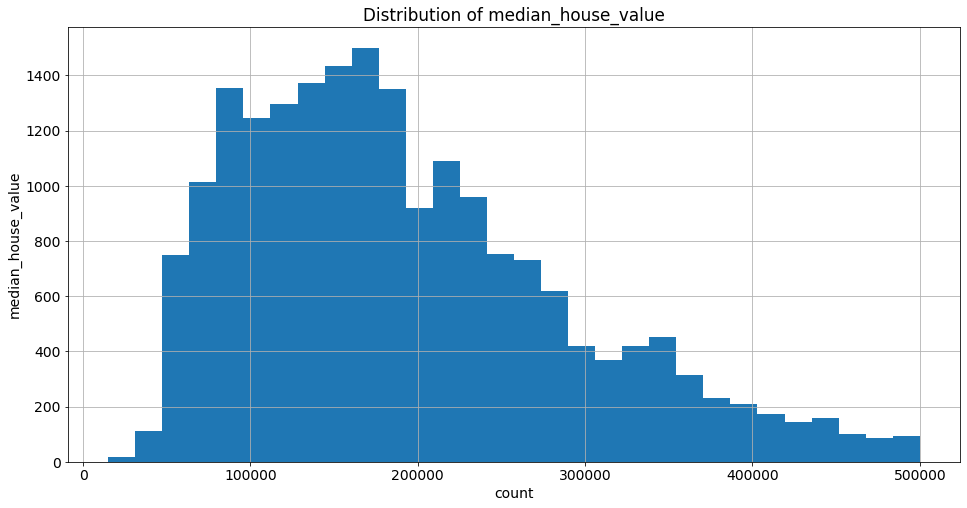

In [17]:
plt.figure(figsize=(16, 8))

df['median_house_value'].hist(bins=30)
plt.xlabel('count')
plt.ylabel('median_house_value')

plt.title('Distribution of median_house_value')
plt.show()

In [18]:
df.columns.tolist()

['index',
 'longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 '<1H OCEAN',
 'INLAND',
 'NEAR BAY',
 'NEAR OCEAN',
 'median_house_value']

In [19]:
df['ocean_proximity'].value_counts()

KeyError: 'ocean_proximity'

In [20]:
features_names = ['longitude', 
                  'latitude',
                  'housing_median_age',
                  'total_rooms',
                  'total_bedrooms',
                  'population',
                  'households',
                  'median_income',
                  '<1H OCEAN',
                  'INLAND',
                  'NEAR BAY',
                  'NEAR OCEAN']

target_name = 'median_house_value'

In [21]:
df = df[features_names + [target_name]]
df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,1,0,452600.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,1,0,358500.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,1,0,352100.0


#### Сохранение датасета

In [22]:
df.to_csv(PREPEARED_DATASET_PATH, index=False, encoding='utf-8')

### Разбиение на train и test

In [23]:
X = df[features_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [50]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print( "R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
            "MSE:\t" + str(round(mse(true_values, pred_values), 3)) + "\n" +
            "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3))
          )
    plt.figure(figsize=(10, 10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    
    plt.show()

### Линейная регрессия

R2:	61.18 %
MSE:	3663449364.1
RMSE:	60526.435


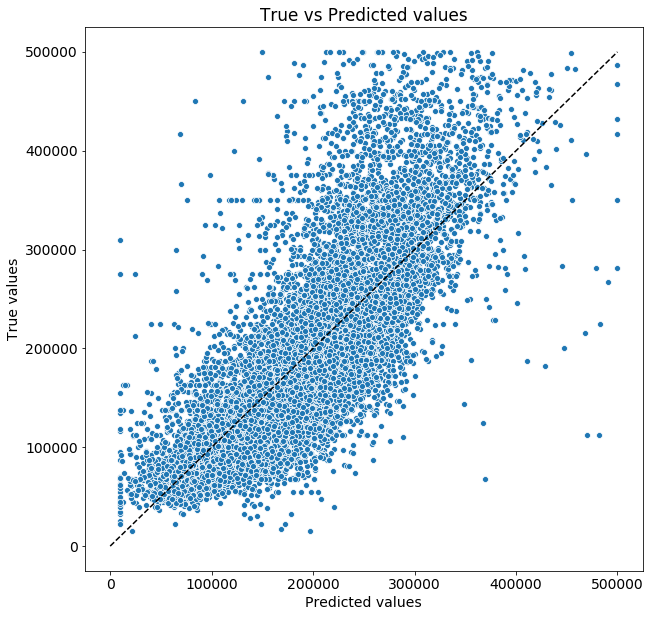

In [46]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)

y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

R2:	60.940000000000005 %
MSE:	3816865602.929
RMSE:	61780.787


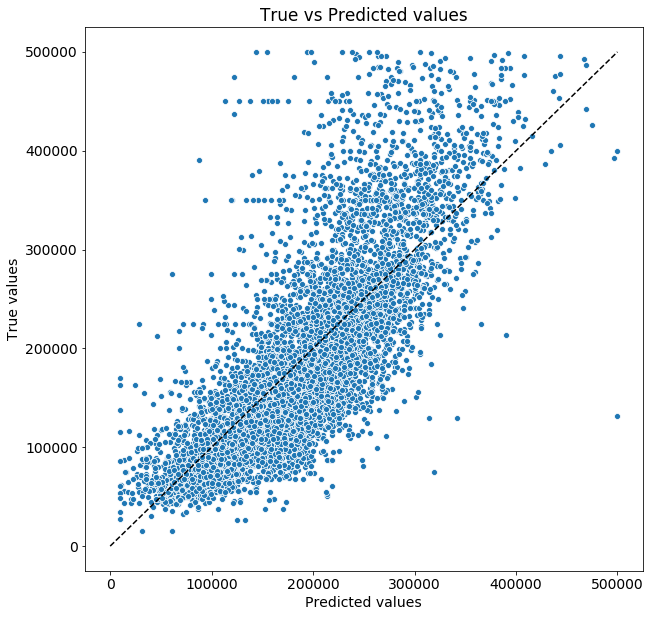

In [47]:
y_test_preds = lr_model.predict(X_test)
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)
evaluate_preds(y_test, y_test_preds)

### Деревья решений

Пример - сколько времени человек потратит на онлайн игры (0- 24 часа в день)

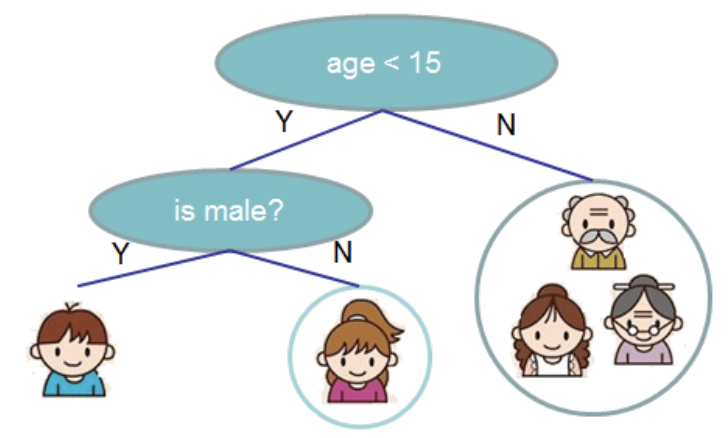

In [27]:
Image(filename='Webinar/dt_explained.png', width=716, height=455)

Пример моделирования

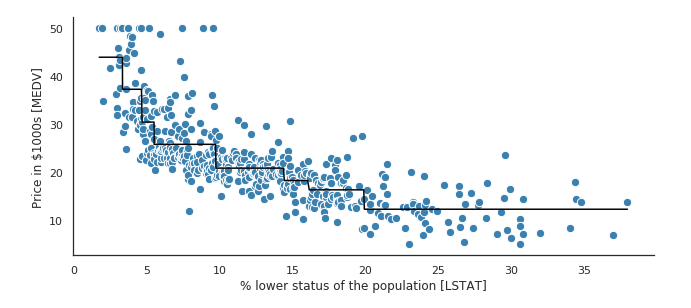

In [28]:
Image(filename='Webinar/dt_example.png')

R2:	0.75
MSE:	2358949797.157
RMSE:	48569.021


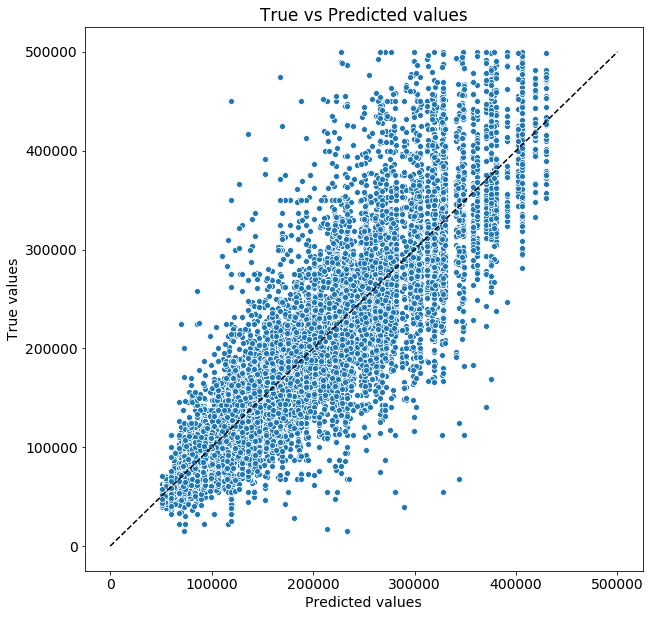

In [51]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                max_depth=20, # было 30
                                min_samples_leaf=30, # было 10
                                random_state=42)

dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)
# R2 было 83.7%

R2:	0.692
MSE:	3010581708.971
RMSE:	54868.768


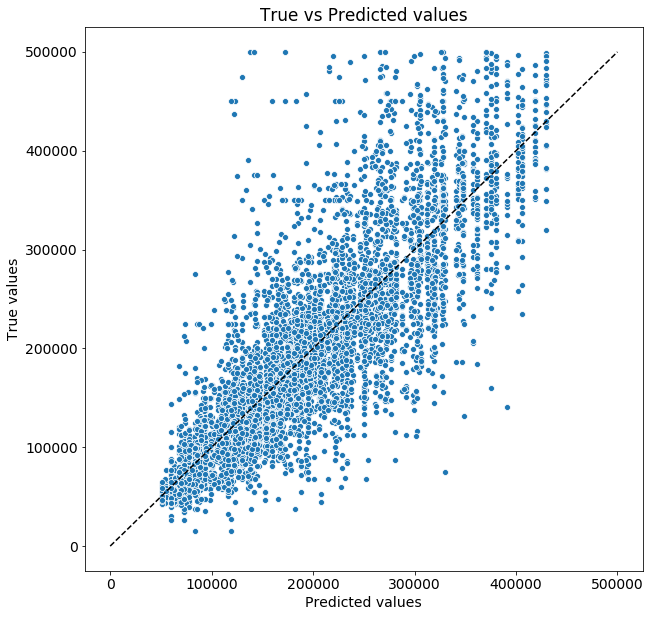

In [52]:
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### Cлучайный лес

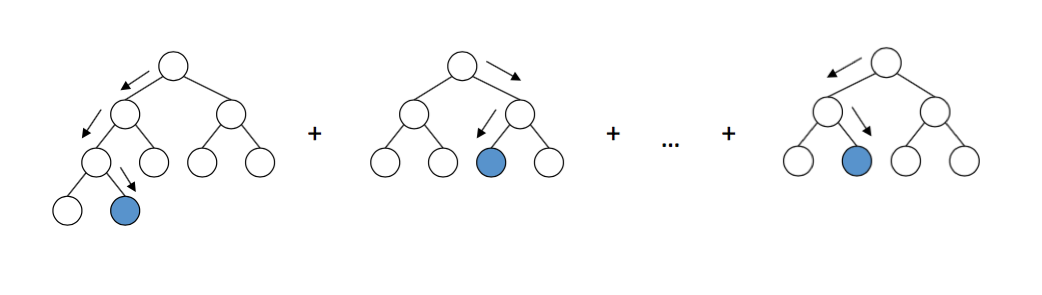

In [54]:
Image(filename='Webinar/rf_explained.png')

R2:	0.768
MSE:	2187135395.648
RMSE:	46766.819


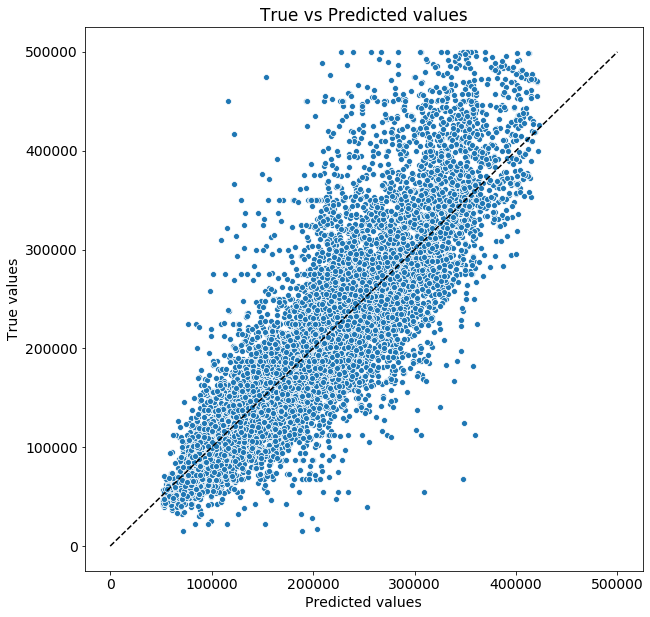

In [56]:
rf_model = RandomForestRegressor(criterion='mse',
                                max_depth=20,
                                min_samples_leaf=30,
                                random_state=42,
                                n_estimators=100)

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.722
MSE:	2713475103.799
RMSE:	52091.027


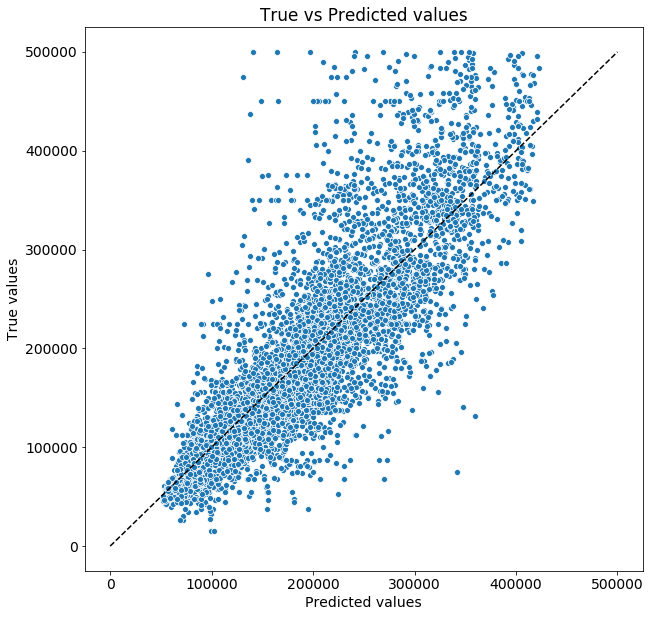

In [57]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### Градиентный бустинг

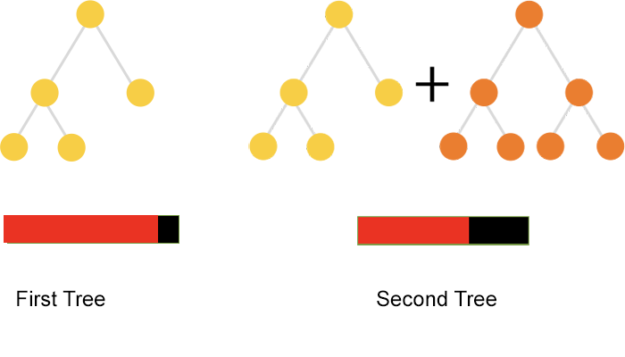

In [58]:
Image(filename='Webinar/gb_explained.png')

R2:	0.89
MSE:	1034357996.841
RMSE:	32161.436


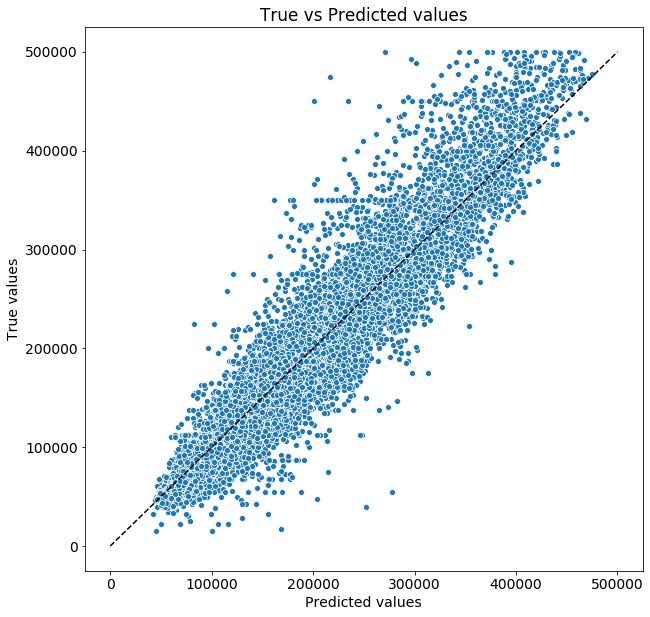

In [69]:
lgb_model = LGBMRegressor(criterion='mse',
                          max_depth=10,
                          min_samples_leaf=30,
                          random_state=42,
                          n_estimators=200)

lgb_model.fit(X_train, y_train)
y_train_preds = lgb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.799
MSE:	1964743871.919
RMSE:	44325.431


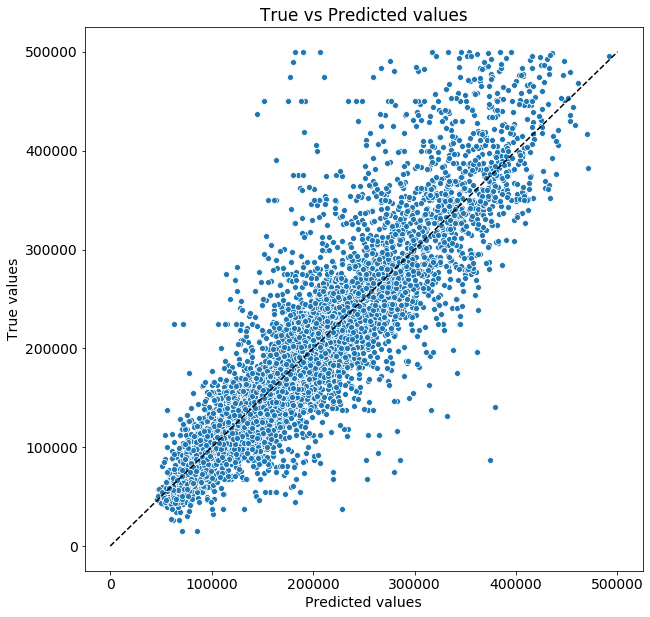

In [70]:
y_test_preds = lgb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### Настройка модели и кросс-валидация

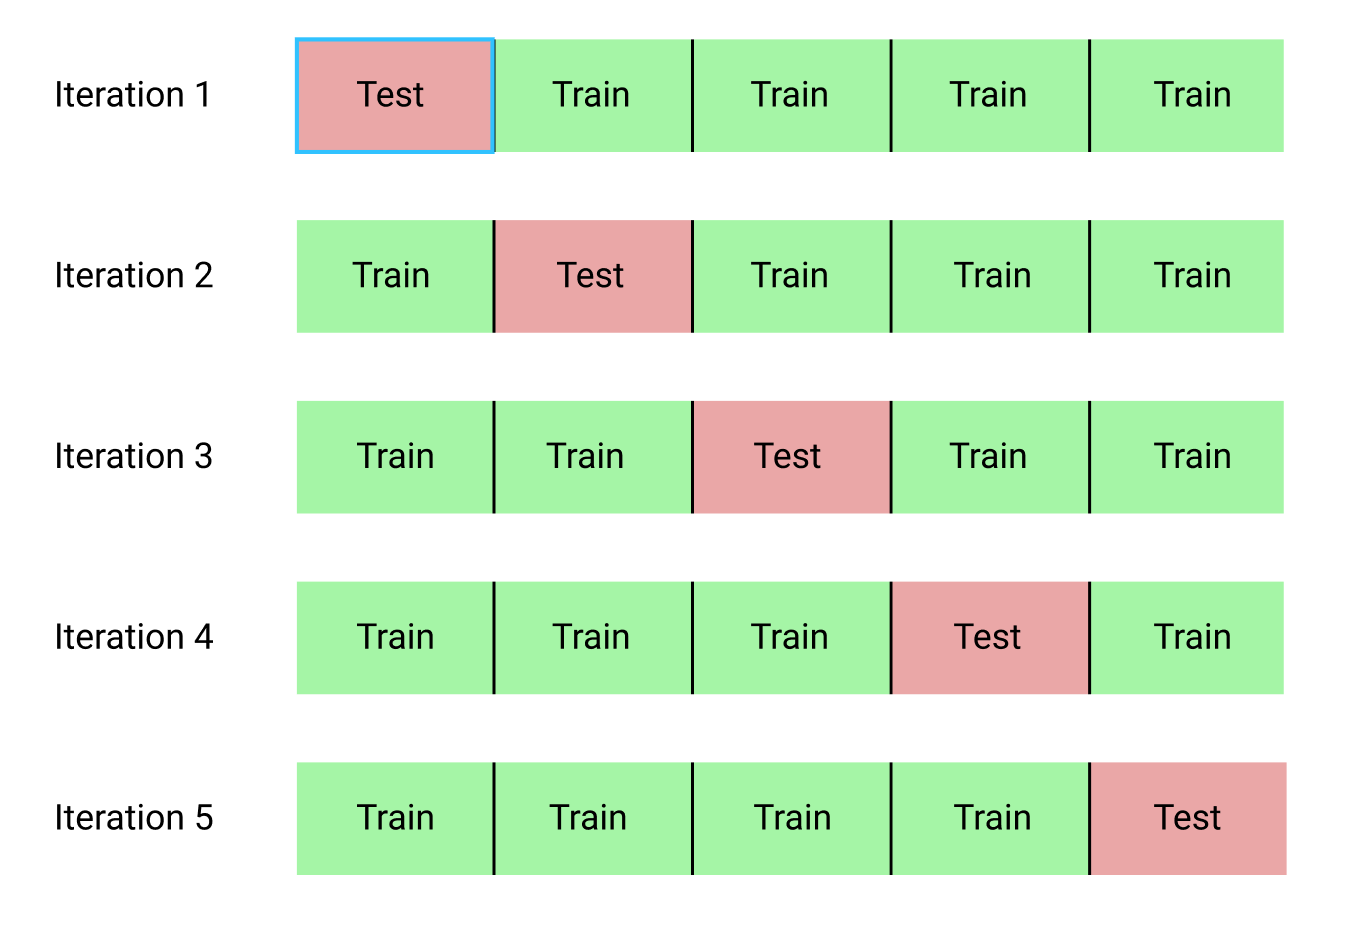

In [73]:
Image(filename='Webinar/kfold.png', height=500, width=500)

Автоматический подбор параметров

In [74]:
lgb_model = LGBMRegressor(criterion='mse',
                         min_samples_leaf=10,
                         random_state=42)

In [77]:
params = {'n_estimators':[50, 100, 200, 400],
         'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(lgb_model, 
                  params, 
                  scoring='r2',
                  cv=KFold(n_splits=5, # к (количество разбиений) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1) # -1 - будет считать на всех доступных потоках
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, criterion='mse',
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001,
                                     min_samples_leaf=10, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [

In [78]:
res = pd.DataFrame(gs.cv_results_)
res.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.176367,0.010674,0.033984,0.005438,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.675878,0.694640,0.677939,0.685249,0.658805,0.678503,0.011842,16
1,0.260464,0.006864,0.044442,0.006037,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.730435,0.752586,0.726546,0.739994,0.713109,0.732535,0.013232,15
2,0.404631,0.018765,0.058111,0.006364,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.758448,0.784680,0.765202,0.776633,0.747999,0.766593,0.012977,13


In [79]:
gs.best_params_

{'max_depth': 7, 'n_estimators': 400}

In [80]:
gs.best_score_

0.8078337952190586

R2:	0.923
MSE:	725402860.84
RMSE:	26933.304


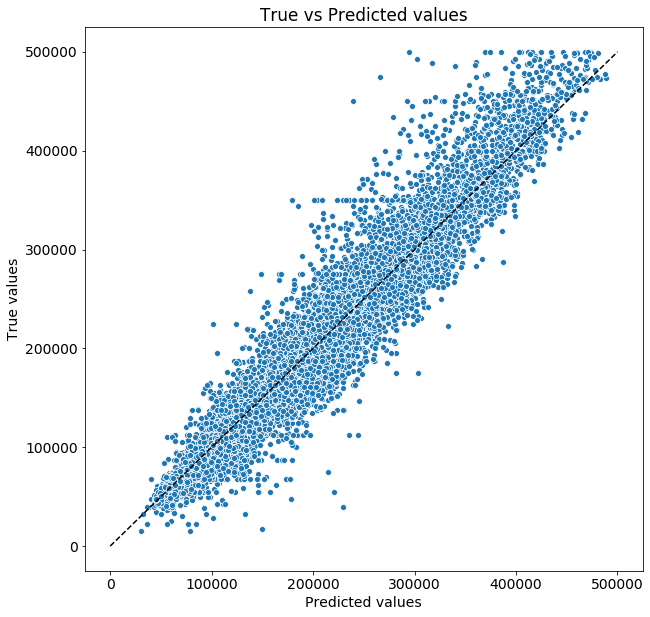

In [82]:
final_model = LGBMRegressor(criterion='mse',
                          max_depth=7,
                          min_samples_leaf=10,
                          random_state=42,
                          n_estimators=400)
final_model.fit(X_train, y_train)
y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.81
MSE:	1860461672.329
RMSE:	43133.069


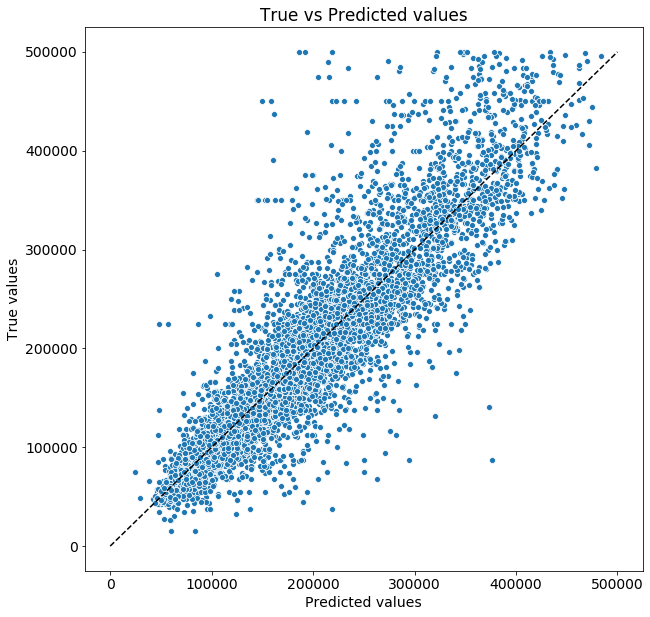

In [83]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### Анализ прогнозов

#### Оценка важности фичей

In [84]:
features_importances = pd.DataFrame(zip(X_train.columns,
                                       final_model.feature_importances_ / final_model.feature_importances_.sum()),
                                   columns=['features_names', 'importance'])

features_importances.sort_values(by='importance', ascending=False, inplace=True)

#### Самые важные фичи

In [86]:
features_importances.head(5)

,features_names,importance
1,latitude,0.173969
0,longitude,0.173457
7,median_income,0.139021
5,population,0.118565
3,total_rooms,0.101091


#### Самые незначимые фичи

In [93]:
features_importances.tail(5)

,features_names,importance
6,households,0.078588
9,INLAND,0.014831
8,<1H OCEAN,0.011422
11,NEAR OCEAN,0.006052
10,NEAR BAY,0.002131


Похоже категориальные фичи оказались не нужны. Оценим их сумму, что бы понимать суммарную значимост исходной переменной и посмотрим ее значимост по остальным переменным

In [91]:
features_importances.tail(4)['importance'].sum()

0.03443573133310603

Выберем переменные со значимостью менее чем суммарная по нашим думми переменным

In [92]:
features_importances[features_importances['importance'] < features_importances.tail(4)['importance'].sum()]

,features_names,importance
9,INLAND,0.014831
8,<1H OCEAN,0.011422
11,NEAR OCEAN,0.006052
10,NEAR BAY,0.002131


Упс - их нет. Значит эти фичи можно удалить. По видимому эту информацию несет в себе широта и долгота

### Сохранение модели

In [96]:
features_importances.to_csv(REPORTS_FILE_PATH + 'features_importances.csv', index=False)

In [99]:
with open(MODEL_FILE_PATH + 'final_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

In [100]:
with open(MODEL_FILE_PATH + 'final_model.pkl', 'rb') as file:
    my_model = pickle.load(file)
    
my_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              criterion='mse', importance_type='split', learning_rate=0.1,
              max_depth=7, min_child_samples=20, min_child_weight=0.001,
              min_samples_leaf=10, min_split_gain=0.0, n_estimators=400,
              n_jobs=-1, num_leaves=31, objective=None, random_state=42,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

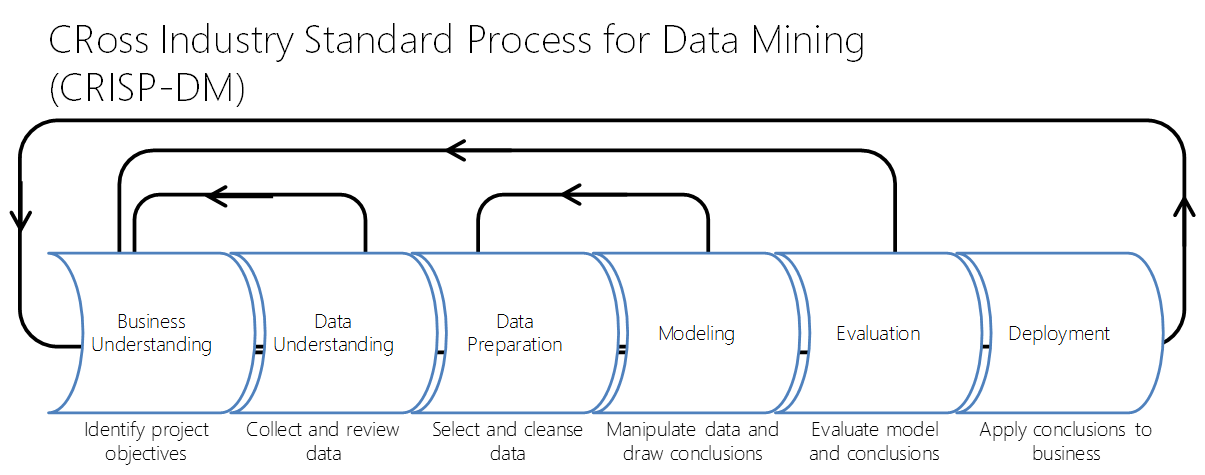

In [101]:
Image(filename='Webinar/ds_pipeline.png')